In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn

import sklearn

In [2]:
data = pd.read_csv("/content/attribution_data.csv")
data.head()

,customer_id,time,interaction,conversion,conversion_value,channel
0,A000100,2018-07-22T20:40:41Z,impression,0,0.0,Online Display
1,A000100,2018-07-08T21:53:37Z,impression,0,0.0,Online Video
2,A000100,2018-07-28T08:15:09Z,impression,0,0.0,Facebook
3,A000100,2018-07-20T17:34:47Z,impression,0,0.0,Paid Search
4,A000100,2018-07-12T07:43:32Z,impression,0,0.0,Facebook


In [3]:
data.groupby('channel')['customer_id'].count().reset_index()

,channel,customer_id
0,Facebook,18676
1,Instagram,8037
2,Online Display,7688
3,Online Video,11694
4,Paid Search,16388


In [4]:
data['channel'].value_counts(normalize=True) * 100

,proportion
channel,
Facebook,29.889730
Paid Search,26.227934
Online Video,18.715491
Instagram,12.862699
Online Display,12.304147


In [5]:
data['interaction'].value_counts(normalize=True) * 100

,proportion
interaction,
impression,97.0584
conversion,2.9416


In [6]:
## Create a function to clean up the data and make it ready for the plots
def input_data_networkx(input_df = data, count_col = 'customer_id', filter_col = 'interaction', df_filter = ['impression'],
                        sort_cols = ['customer_id', 'time']):
  df = data[data[filter_col].isin(df_filter)].sort_values(by = sort_cols)
  df['TO'] = df.groupby(count_col)['channel'].shift(-1)
  df['TO'] = np.where(df['TO'].isna(), df[filter_col], df['TO'])
  df = df[sort_cols + ['channel', 'TO']].rename(columns={'channel': 'FROM'})
  df = df.merge(df.groupby(['FROM', 'TO'])[count_col].count().reset_index().rename(columns={'customer_id':'PATH_FREQ'}),
                on = ['FROM', 'TO'])
  return df

In [23]:
df = input_data_networkx()
df.head()

,customer_id,time,FROM,TO,PATH_FREQ
0,A000100,2018-07-08T21:53:37Z,Online Video,Facebook,3003
1,A000100,2018-07-12T07:43:32Z,Facebook,Paid Search,3819
2,A000100,2018-07-19T16:37:23Z,Paid Search,Paid Search,3864
3,A000100,2018-07-20T17:34:47Z,Paid Search,Online Display,1789
4,A000100,2018-07-22T20:40:41Z,Online Display,Facebook,2023


In [24]:
# df = data[data['interaction']=='impression'].sort_values(by = ['customer_id', 'time'])
# df['TO'] = df.groupby('customer_id')['channel'].shift(-1)
# df['TO'] = np.where(df['TO'].isna(), df['interaction'], df['TO'])
# df = df[['customer_id', 'time', 'channel', 'TO']].rename(columns={'channel': 'FROM'})
# df = df.merge(df.groupby(['FROM', 'TO'])['customer_id'].count().reset_index().rename(columns={'customer_id':'PATH_FREQ'}),
#               on = ['FROM', 'TO'])
# df.head()

2. Config the parameters in the `networkx` function and make the network plots by inputting the data prepared in *Step 1*

In [9]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib.pyplot import figure

In [10]:
print(f'NetworkX version: {nx.__version__}')

NetworkX version: 3.4.2


**Impression**

In [25]:
G = nx.from_pandas_edgelist(df, source='FROM', target='TO', edge_attr=True, create_using=nx.DiGraph())
nodes, degree = map(list, zip(*list(G.degree())))
nodes, degree

(['Online Video',
  'Facebook',
  'Paid Search',
  'Online Display',
  'impression',
  'Instagram'],
 [11, 11, 11, 11, 5, 11])

In [26]:
# Recalculate the degree (aka node size)
node_size = pd.concat([data.groupby('channel')['customer_id'].count().reset_index().rename(columns={'channel': 'NODE', 'customer_id': 'SIZE'}),
                      df[df['TO'].isin(['impression'])].groupby('TO')['customer_id'].count().reset_index().rename(columns={'TO': 'NODE', 'customer_id': 'SIZE'})])
node_size['NODE_c'] = pd.Categorical(node_size['NODE'], categories=['Online Video','Facebook','Paid Search',
                                                                    'Online Display','impression','Instagram'], ordered=True)
node_size = node_size.sort_values(by='NODE_c')
node_size_list = list(zip(node_size['NODE'], node_size['SIZE']))
node_size_list

[('Online Video', 11694),
 ('Facebook', 18676),
 ('Paid Search', 16388),
 ('Online Display', 7688),
 ('impression', 7894),
 ('Instagram', 8037)]

<ipython-input-31-30f3c97fc798>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(G, with_labels=True, cmap=plt.cm.get_cmap('Set3'), node_color=colors, font_size=10,


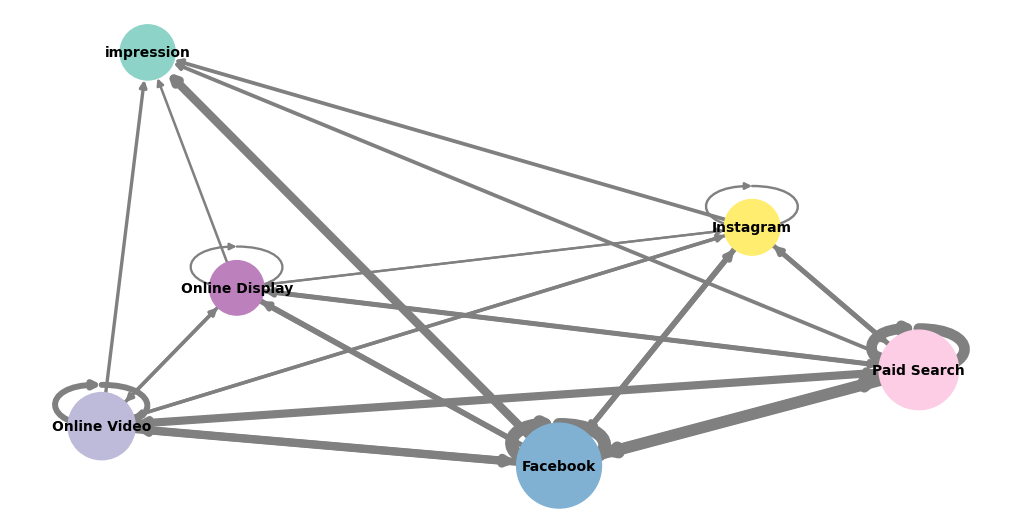

In [31]:
## Make the plots for customers with impression and conversion respectively
# Plot for impression
figure(figsize=(10, 5))
G = nx.from_pandas_edgelist(df, source='FROM', target='TO', edge_attr=True, create_using=nx.DiGraph())
nodes, degree = map(list, zip(*node_size_list))
edges, freqs = zip(*nx.get_edge_attributes(G, 'PATH_FREQ').items())
colors = []
i = 1
for node in G:
  if node == 'conversion' or node == 'impression':
    colors.append(0)
  else:
    colors.append(i)
    i = i+1

nx.draw(G, with_labels=True, cmap=plt.cm.get_cmap('Set3'), node_color=colors, font_size=10,
        font_weight='bold', edge_color='gray', width = [int(f)/500 for f in freqs],
        node_size=[int(d)/5 for d in degree])
plt.show()

**Conversion**

In [32]:
df = input_data_networkx(df_filter=['conversion'])
df.head()

,customer_id,time,FROM,TO,PATH_FREQ
0,A000104,2018-07-06T19:15:57Z,Instagram,conversion,208
1,A000107,2018-07-04T10:59:00Z,Paid Search,Facebook,22
2,A000107,2018-07-17T17:22:43Z,Facebook,conversion,513
3,A000109,2018-07-22T14:26:29Z,Online Video,conversion,318
4,A000117,2018-07-19T08:12:37Z,Online Display,conversion,206


In [33]:
G = nx.from_pandas_edgelist(df, source='FROM', target='TO', edge_attr=True, create_using=nx.DiGraph())
nodes, degree = map(list, zip(*list(G.degree())))
nodes, degree

(['Instagram',
  'conversion',
  'Paid Search',
  'Facebook',
  'Online Video',
  'Online Display'],
 [11, 5, 11, 11, 10, 10])

In [34]:
# Recalculate the degree (aka node size)
node_size = pd.concat([data.groupby('channel')['customer_id'].count().reset_index().rename(columns={'channel': 'NODE', 'customer_id': 'SIZE'}),
                      df[df['TO'].isin(['impression', 'conversion'])].groupby('TO')['customer_id'].count().reset_index().rename(columns={'TO': 'NODE', 'customer_id': 'SIZE'})])
node_size['NODE_c'] = pd.Categorical(node_size['NODE'], categories=['Instagram', 'conversion', 'Paid Search', 'Facebook', 'Online Video', 'Online Display'], ordered=True)
node_size = node_size.sort_values(by='NODE_c')
node_size_list = list(zip(node_size['NODE'], node_size['SIZE']))
node_size_list

[('Instagram', 8037),
 ('conversion', 1642),
 ('Paid Search', 16388),
 ('Facebook', 18676),
 ('Online Video', 11694),
 ('Online Display', 7688)]

<ipython-input-35-582cbdadfcc7>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(G, with_labels=True, cmap=plt.cm.get_cmap('Set3'), node_color=colors, font_size=10,


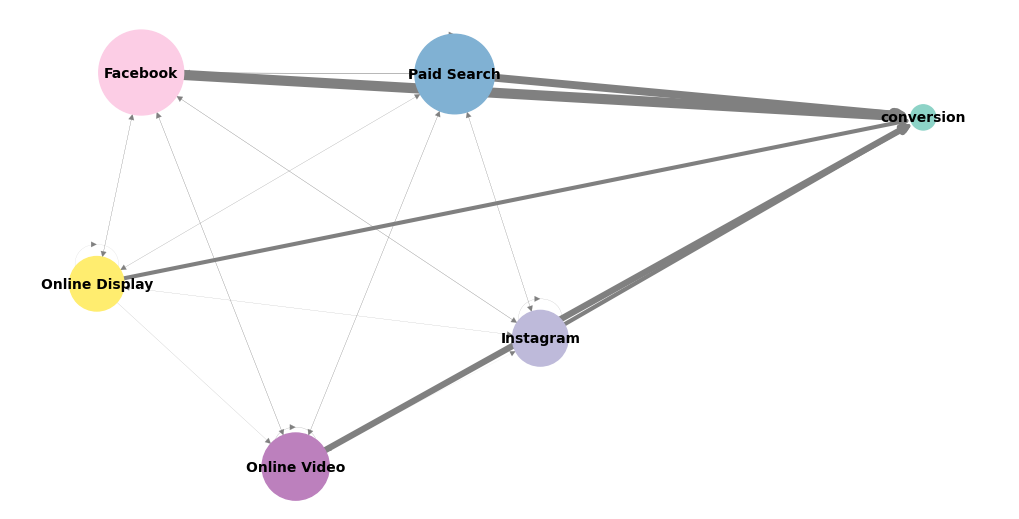

In [35]:
## Make the plots for customers with impression and conversion respectively
# Plot for impression
figure(figsize=(10, 5))
G = nx.from_pandas_edgelist(df, source='FROM', target='TO', edge_attr=True, create_using=nx.DiGraph())
nodes, degree = map(list, zip(*node_size_list))
edges, freqs = zip(*nx.get_edge_attributes(G, 'PATH_FREQ').items())
colors = []
i = 1
for node in G:
  if node == 'conversion' or node == 'impression':
    colors.append(0)
  else:
    colors.append(i)
    i = i+1

nx.draw(G, with_labels=True, cmap=plt.cm.get_cmap('Set3'), node_color=colors, font_size=10,
        font_weight='bold', edge_color='gray', width = [int(f)/70 for f in freqs],
        node_size=[int(d)/5 for d in degree])
plt.show()

In [36]:
data.head()

,customer_id,time,interaction,conversion,conversion_value,channel
0,A000100,2018-07-22T20:40:41Z,impression,0,0.0,Online Display
1,A000100,2018-07-08T21:53:37Z,impression,0,0.0,Online Video
2,A000100,2018-07-28T08:15:09Z,impression,0,0.0,Facebook
3,A000100,2018-07-20T17:34:47Z,impression,0,0.0,Paid Search
4,A000100,2018-07-12T07:43:32Z,impression,0,0.0,Facebook


#### Graph-Based Multi-touch Attribution Model with `NetworkX`
* Graph-based models represent the customer journey as a network of touchpoints, offering a visually intuitive and mathematically robust approach to attribution.
  * Represents touchpoints as nodes and interactions as edges
  * Captures complex relationships and multi-step influences
  * Allows for the application of graph theory algorithms

*Reference: https://medium.com/@xiaotingkuangcu/machine-learning-based-multi-touch-attribution-models-f95e45f7ab0f*

#### PageRank algorithm in `NetworkX`
[Placeholder]

* has_edge: used to check if an edge exists between two nodes in a graph


In [41]:
def graph_attribution(df):
    G = nx.DiGraph()

    for _, user_data in df.groupby('customer_id'):
        touchpoints = user_data['channel'].tolist()
        for i in range(len(touchpoints) - 1):
            if G.has_edge(touchpoints[i], touchpoints[i+1]):
                G[touchpoints[i]][touchpoints[i+1]]['weight'] += 1
            else:
                G.add_edge(touchpoints[i], touchpoints[i+1], weight=1)

    pagerank = nx.pagerank(G, weight='weight')

    # Normalize attribution
    total = sum(pagerank.values())
    attribution = {channel: pagerank.get(channel, 0) / total for channel in df['channel'].unique()}

    return attribution

In [38]:
input_data = data[['customer_id', 'channel', 'time', 'conversion']].sort_values(['customer_id', 'time']).reset_index(drop=True)
input_data.head(3)

,customer_id,channel,time,conversion
0,A000100,Online Video,2018-07-08T21:53:37Z,0
1,A000100,Facebook,2018-07-12T07:43:32Z,0
2,A000100,Paid Search,2018-07-19T16:37:23Z,0


In [42]:
print("\nGraph-Based (PageRank) Attribution:")
print(graph_attribution(input_data))


Graph-Based (PageRank) Attribution:
{'Online Video': 0.1961781118761615, 'Facebook': 0.28398088343342215, 'Paid Search': 0.24440814175316672, 'Online Display': 0.1352888353964901, 'Instagram': 0.1401440275407597}


In [43]:
print("\nGraph-Based (PageRank) Attribution:")
print(graph_attribution(input_data[input_data['conversion']==1]))


Graph-Based (PageRank) Attribution:
{'Instagram': 0.1564528090072539, 'Paid Search': 0.20127895260448295, 'Facebook': 0.3410203531254325, 'Online Video': 0.16092454688330185, 'Online Display': 0.14032333837952882}
